In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Remember to connect to VPN first 
DATABASE_URL = "internal-mongo-elb-624130134.us-east-1.elb.amazonaws.com"
USER, PWD = 'analyzer', 'hyperpilot'
METRIC_DB, CONFIG_DB = 'metricdb', 'configdb'

In [10]:
import json
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
from pymongo import MongoClient

In [11]:
def find_all(collection, filt={}, proj=None, database=METRIC_DB, return_list=False):
    """ A wrapper for 'find' to ensure the connection will be closed.
    Args:
        collection(str): mongoDB collection
        filt(dict): mongoDB filter
        proj(dict): mongoDB projection
        database(str): name of database
    Return:
        documents(cursor): mongoDB cursor 
    """
    try:
        client = MongoClient(DATABASE_URL, waitQueueTimeoutMS=200)
        db = client[database]
        db.authenticate(USER, PWD, source=database)
        if proj:
            documents = db[collection].find(filt, proj)
        else:
            documents = db[collection].find(filt)
    except Exception as e:
        raise e
    else:
        return documents if not return_list else list(documents)
    finally:
        client.close()


def find_one(collection, filt, proj=None, database=METRIC_DB):
    """ A wrapper for 'findOne' to ensure the connection will be closed.
    Args:
        collection(str): mongoDB collection
        filt(dict): mongoDB filter
        proj(dict): mongoDB projection
        database(str): name of database
    Return:
        documents(cursor): mongoDB cursor 
    """
    try:
        client = MongoClient(DATABASE_URL, waitQueueTimeoutMS=200)
        db = client[database]
        db.authenticate(USER, PWD, source=database)
        if proj:
            document = db[collection].find_one(filt, proj)
        else:
            document = db[collection].find_one(filt)
    except Exception as e:
        raise e
    else:
        return document
    finally:
        client.close()

In [312]:
def create_calibration_dataframe():
    cali_objs = find_all(collection='calibration', return_list=True)

    dfs = []
    for cali_obj in cali_objs:
        tmp_df = pd.read_json(json.dumps(cali_obj['testResult']))
        for i in [i for i in cali_obj if i not in ['testResult', '_id', 'qosMetrics']]:
            tmp_df[i] = cali_obj[i]
        dfs.append(tmp_df)
    df = pd.concat(dfs)
    return df

In [55]:
def create_profiling_dataframe():
    prof_objs = find_all(collection='profiling', return_list=True)
    dfs = []
    for prof_obj in prof_objs:
        tmp_df = pd.DataFrame([pd.Series(i) for i in prof_obj['testResult']])
        for i in [i for i in prof_obj if i not in ['testResult', '_id', 'benchmarks', 'serviceNoe', 'services']]:
            tmp_df[i] = prof_obj[i]
        dfs.append(tmp_df)
    df = pd.concat(dfs)
    
    return df

In [73]:
prof_df = create_profiling_dataframe()
prof_df.columns

Index([u'benchmark', u'intensity', u'qos', u'toleratedInterference',
       u'serviceInTest', u'appName', u'testDuration', u'sloTolerance',
       u'numServices', u'appCapacity', u'loadTester', u'testId',
       u'serviceNode', u'sloMetric'],
      dtype='object')

In [74]:
cali_df = create_calibration_dataframe()
cali_df.columns

Index([u'loadIntensity', u'qosMetric', u'appName', u'loadTester',
       u'testDuration', u'testId', u'finalIntensity'],
      dtype='object')

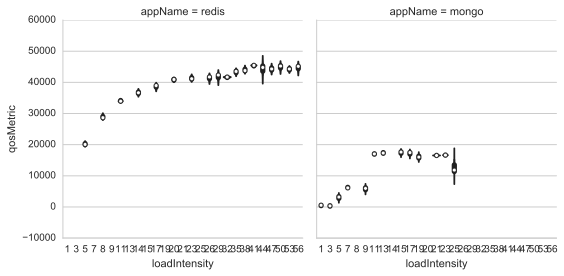

In [85]:
g = sns.factorplot(x="loadIntensity", y="qosMetric", col="appName", data=cali_df,
                   palette="YlGnBu_d", kind="violin", ci=100)

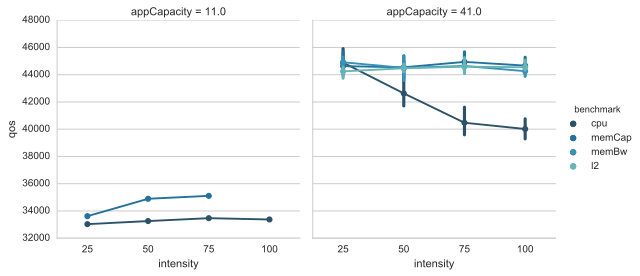

In [90]:
g = sns.factorplot(x="intensity", y="qos", col="appCapacity", hue='benchmark', data=prof_df,
                   palette="YlGnBu_d", scale=0.6, ci=100)

In [92]:
prof_df

,benchmark,intensity,qos,toleratedInterference,serviceInTest,appName,testDuration,sloTolerance,numServices,appCapacity,loadTester,testId,serviceNode,sloMetric
0,cpu,25,33031.64,0.0,redis,redis,,0.0,1,11.0,redis-bench,calibrate-f5064a1c-0c90-4102-712a-6d588d8a3302,,
1,cpu,50,33257.95,0.0,redis,redis,,0.0,1,11.0,redis-bench,calibrate-f5064a1c-0c90-4102-712a-6d588d8a3302,,
2,cpu,75,33469.44,0.0,redis,redis,,0.0,1,11.0,redis-bench,calibrate-f5064a1c-0c90-4102-712a-6d588d8a3302,,
3,cpu,100,33373.38,0.0,redis,redis,,0.0,1,11.0,redis-bench,calibrate-f5064a1c-0c90-4102-712a-6d588d8a3302,,
4,memCap,25,33615.71,0.0,redis,redis,,0.0,1,11.0,redis-bench,calibrate-f5064a1c-0c90-4102-712a-6d588d8a3302,,
5,memCap,50,34894.27,0.0,redis,redis,,0.0,1,11.0,redis-bench,calibrate-f5064a1c-0c90-4102-712a-6d588d8a3302,,
6,memCap,75,35107.43,0.0,redis,redis,,0.0,1,11.0,redis-bench,calibrate-f5064a1c-0c90-4102-712a-6d588d8a3302,,
0,cpu,25,47323.84,0.0,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,
1,cpu,50,48419.12,0.0,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,
2,cpu,75,42678.50,0.0,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,


In [86]:
cali_df

,loadIntensity,qosMetric,appName,loadTester,testDuration,testId,finalIntensity
0,5,20069.000000,redis,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,41.0
1,5,20578.000000,redis,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,41.0
2,5,19916.000000,redis,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,41.0
3,8,28609.000000,redis,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,41.0
4,8,28668.000000,redis,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,41.0
5,8,29393.000000,redis,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,41.0
6,11,33922.000000,redis,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,41.0
7,11,34357.000000,redis,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,41.0
8,11,33944.000000,redis,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,41.0
9,14,37131.000000,redis,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,41.0


In [20]:
# kind : {point, bar, count, box, violin, strip}

In [281]:
prof_df = prof_df.sort_values('intensity', ascending=True)
tests = prof_df.groupby(['testId', 'benchmark', 'intensity'])['qos'].mean()
tests = pd.DataFrame(tests).reset_index()
reduced = tests.groupby(['testId', 'benchmark'])

dfs = pd.DataFrame(columns=['testId', 'benchmark', 'tolerated interference'])

for idx, (i, j) in enumerate(reduced):
    dfs.loc[idx] = [i[0], i[1], j['qos'].max()-j['qos'].min()]    

feature_names = list(set(dfs['benchmark']))

apps,features = [], []
for i, j in dfs.groupby('testId'):
    apps.append(i)
    feature = []
    for k in feature_names:
        try:
            feature.append(j.loc[j['benchmark'] == k]['tolerated interference'].values[0])
        except:
            feature.append(0)
    features.append(feature)

calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb [653.8700000000099, 344.61400000001595, 4872.4090909090883, 400.02272727272793]
calibrate-f5064a1c-0c90-4102-712a-6d588d8a3302 [0, 0, 437.80000000000291, 1491.7200000000012]


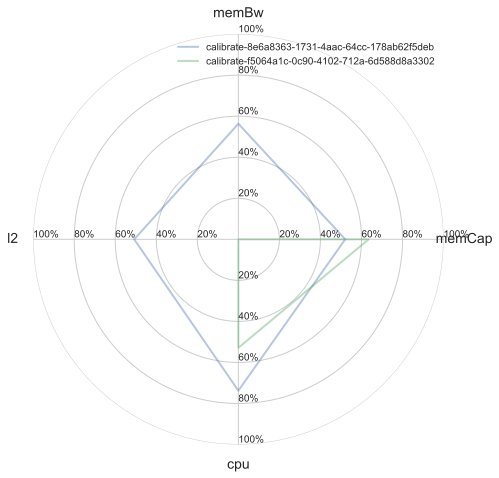

In [315]:
import numpy as np
import pylab as pl

class Radar(object):

    def __init__(self, fig, titles, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.95, 0.95]

        self.n = len(titles)
        self.angles = np.arange(90, 90+360, 360.0/self.n)
        self.axes = [fig.add_axes(rect, projection="polar", label="axes%d" % i) 
                         for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=titles, fontsize=14)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(0, 5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        
fig = pl.figure(figsize=(6, 6))

titles = feature_names

labels = [
    ['{}%'.format(i) for i in range(20, 101, 20)]
]*len(feature_names)

import numpy as np
radar = Radar(fig, titles, labels)
for i, j in zip(apps, features):
    print i, j
    radar.plot(np.log10(1+np.array(j)), '-', lw=2, alpha=0.4, label=i)
# radar.plot([1, 3, 2, 5, 4],  "-", lw=2, color="b", alpha=0.4, label="first")
# radar.plot([2.3, 2, 3, 3, 2],"-", lw=2, color="r", alpha=0.4, label="second")
# radar.plot([3, 4, 3, 4, 2], "-", lw=2, color="g", alpha=0.4, label="third")
radar.ax.legend()